In [19]:
!pip install torchvision
!pip install timm

  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
Using cached timm-1.0.15-py3-none-any.whl (2.4 MB)

   ---------------------------------------- 0/4 [tqdm]
   -------------------- ------------------- 2/4 [huggingface_hub]
   -------------------- ------------------- 2/4 [huggingface_hub]
   -------------------- ------------------- 2/4 [huggingface_hub]
   -------------------- ------------------- 2/4 [huggingface_hub]
   -------------------- ------------------- 2/4 [huggingface_hub]
   -------------------- ------------------- 2/4 [huggingface_hub]
   ------------------------------ --------- 3/4 [timm]
   ------------------------------ --------- 3/4 [timm]
   ------------------------------ --------- 3/4 [timm]
   ------------------------------ --------- 3/4 [timm]
   ------------------------------ --------- 3/4 [timm]
   ------------------------------ --------- 3/4 [timm]
   ------------------------------ --------- 3/4 [timm]
   ------------------------------ --------- 3/4 [ti

In [20]:
# 1. Importar bibliotecas necesarias
import torch
from sklearn.metrics import classification_report
import mlflow
import mlflow.pytorch
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import joblib
from torchvision import transforms
import pandas as pd

In [43]:
# 2. Definir rutas y cargar etiquetas
IMG_DIR = '../data/images'
labels_path = '../artifacts/clean_labels.csv'
df = pd.read_csv(labels_path)
MODEL_NAME = 'vit_base_patch16_224'
BATCH_SIZE = 16
EPOCHS = 3
l_r=1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Dataset personalizado
class ImageCSVData(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [11]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['Category'])

# Dividir en train y validación
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [21]:
# Datasets y Dataloaders
train_dataset = ImageCSVData(train_df, IMG_DIR, transform=transform)
val_dataset = ImageCSVData(val_df, IMG_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Modelo
import timm
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(le.classes_))
model.to(DEVICE)

C:\Users\JAVIERS\anaconda3\envs\proyectailive\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [27]:
# Guardar el modelo localmente
joblib.dump(model, "../artifacts/best_model.pkl")
print("✅ Modelo guardado como 'best_model.pkl'")

✅ Modelo guardado como 'best_model.pkl'


C:\Users\JAVIERS\anaconda3\envs\proyectailive\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JAVIERS\anaconda3\envs\proyectailive\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JAVIERS\anaconda3\envs\proyectailive\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz


✅ Evaluación completa.
📊 Accuracy: 0.2714285714285714
🎯 F1-score: 0.33506493506493507


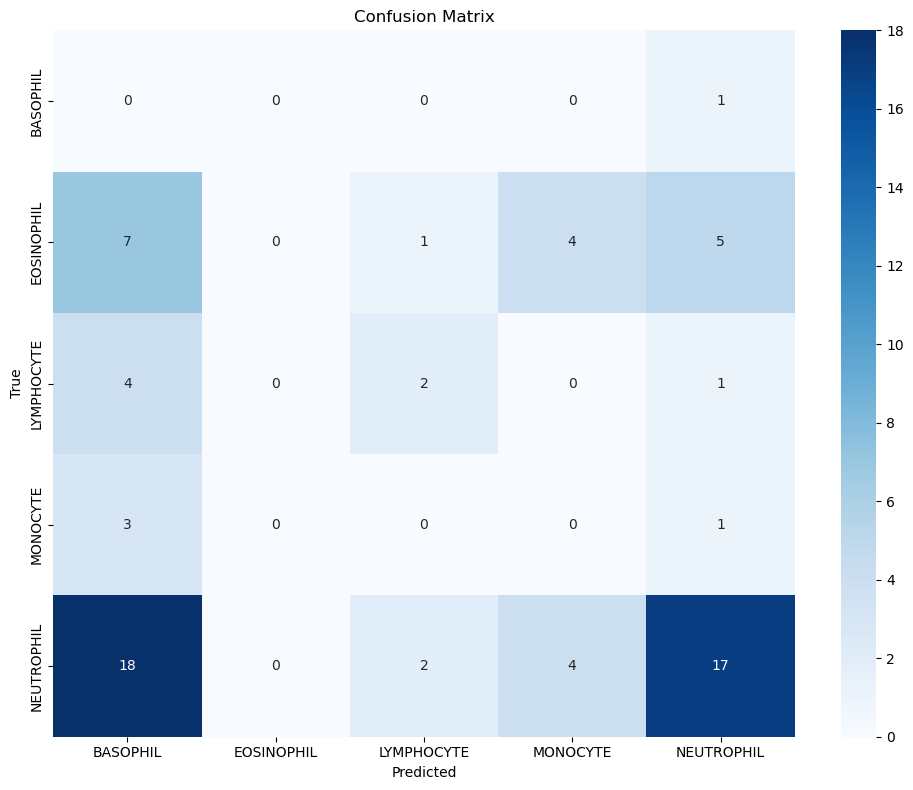

In [45]:
model.eval()
all_preds, all_labels = [], []
import os
from PIL import Image
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
report = classification_report(all_labels, all_preds, target_names=le.classes_)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Guardar clasificación
with open("classification_report.txt", "w") as f:
    f.write(report)

# Matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")

# Registrar con MLflow
mlflow.set_experiment("bloodcell-vit")
with mlflow.start_run():
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("learning_rate", l_r)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

    mlflow.log_artifact("classification_report.txt")
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.pytorch.log_model(model, "model")

print("\n✅ Evaluación completa.")
print("📊 Accuracy:", acc)
print("🎯 F1-score:", f1)